**House Price Prediction Model**

**Import Dataset**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy import stats

In [2]:
df = pd.read_csv("House data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [4]:
print(df.head())

                  date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  2014-05-02 00:00:00   313000.0       3.0       1.50         1340      7912   
1  2014-05-02 00:00:00  2384000.0       5.0       2.50         3650      9050   
2  2014-05-02 00:00:00   342000.0       3.0       2.00         1930     11947   
3  2014-05-02 00:00:00   420000.0       3.0       2.25         2000      8030   
4  2014-05-02 00:00:00   550000.0       4.0       2.50         1940     10500   

   floors  waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
0     1.5           0     0          3        1340              0      1955   
1     2.0           0     4          5        3370            280      1921   
2     1.0           0     0          4        1930              0      1966   
3     1.0           0     0          4        1000           1000      1963   
4     1.0           0     0          4        1140            800      1976   

   yr_renovated                    str

**2. Preprocess the Dataset**

**i. Remove Meaningless Columns**

In [5]:
df['date'].nunique()

70

In [7]:
# Drop columns
df.drop('date', axis=1, inplace=True)

In [9]:
df.insert(0, "age", 2014-df["yr_built"] )
df.insert(1, "renovated", df["yr_renovated"].apply(lambda x: 1 if x > 0 else 0))
df.insert(2, "age_after_renovated", df.apply( lambda row: 2014- row['yr_renovated'] if row['yr_renovated'] > 0 else 2014 - row['yr_built'], axis=1))
df.drop(['yr_built', 'yr_renovated'], axis=1, inplace=True)

**ii. Remove Null Values**

In [10]:
df.isnull().sum()

,0
age,0
renovated,0
age_after_renovated,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0


**iii. Remove Outliers**

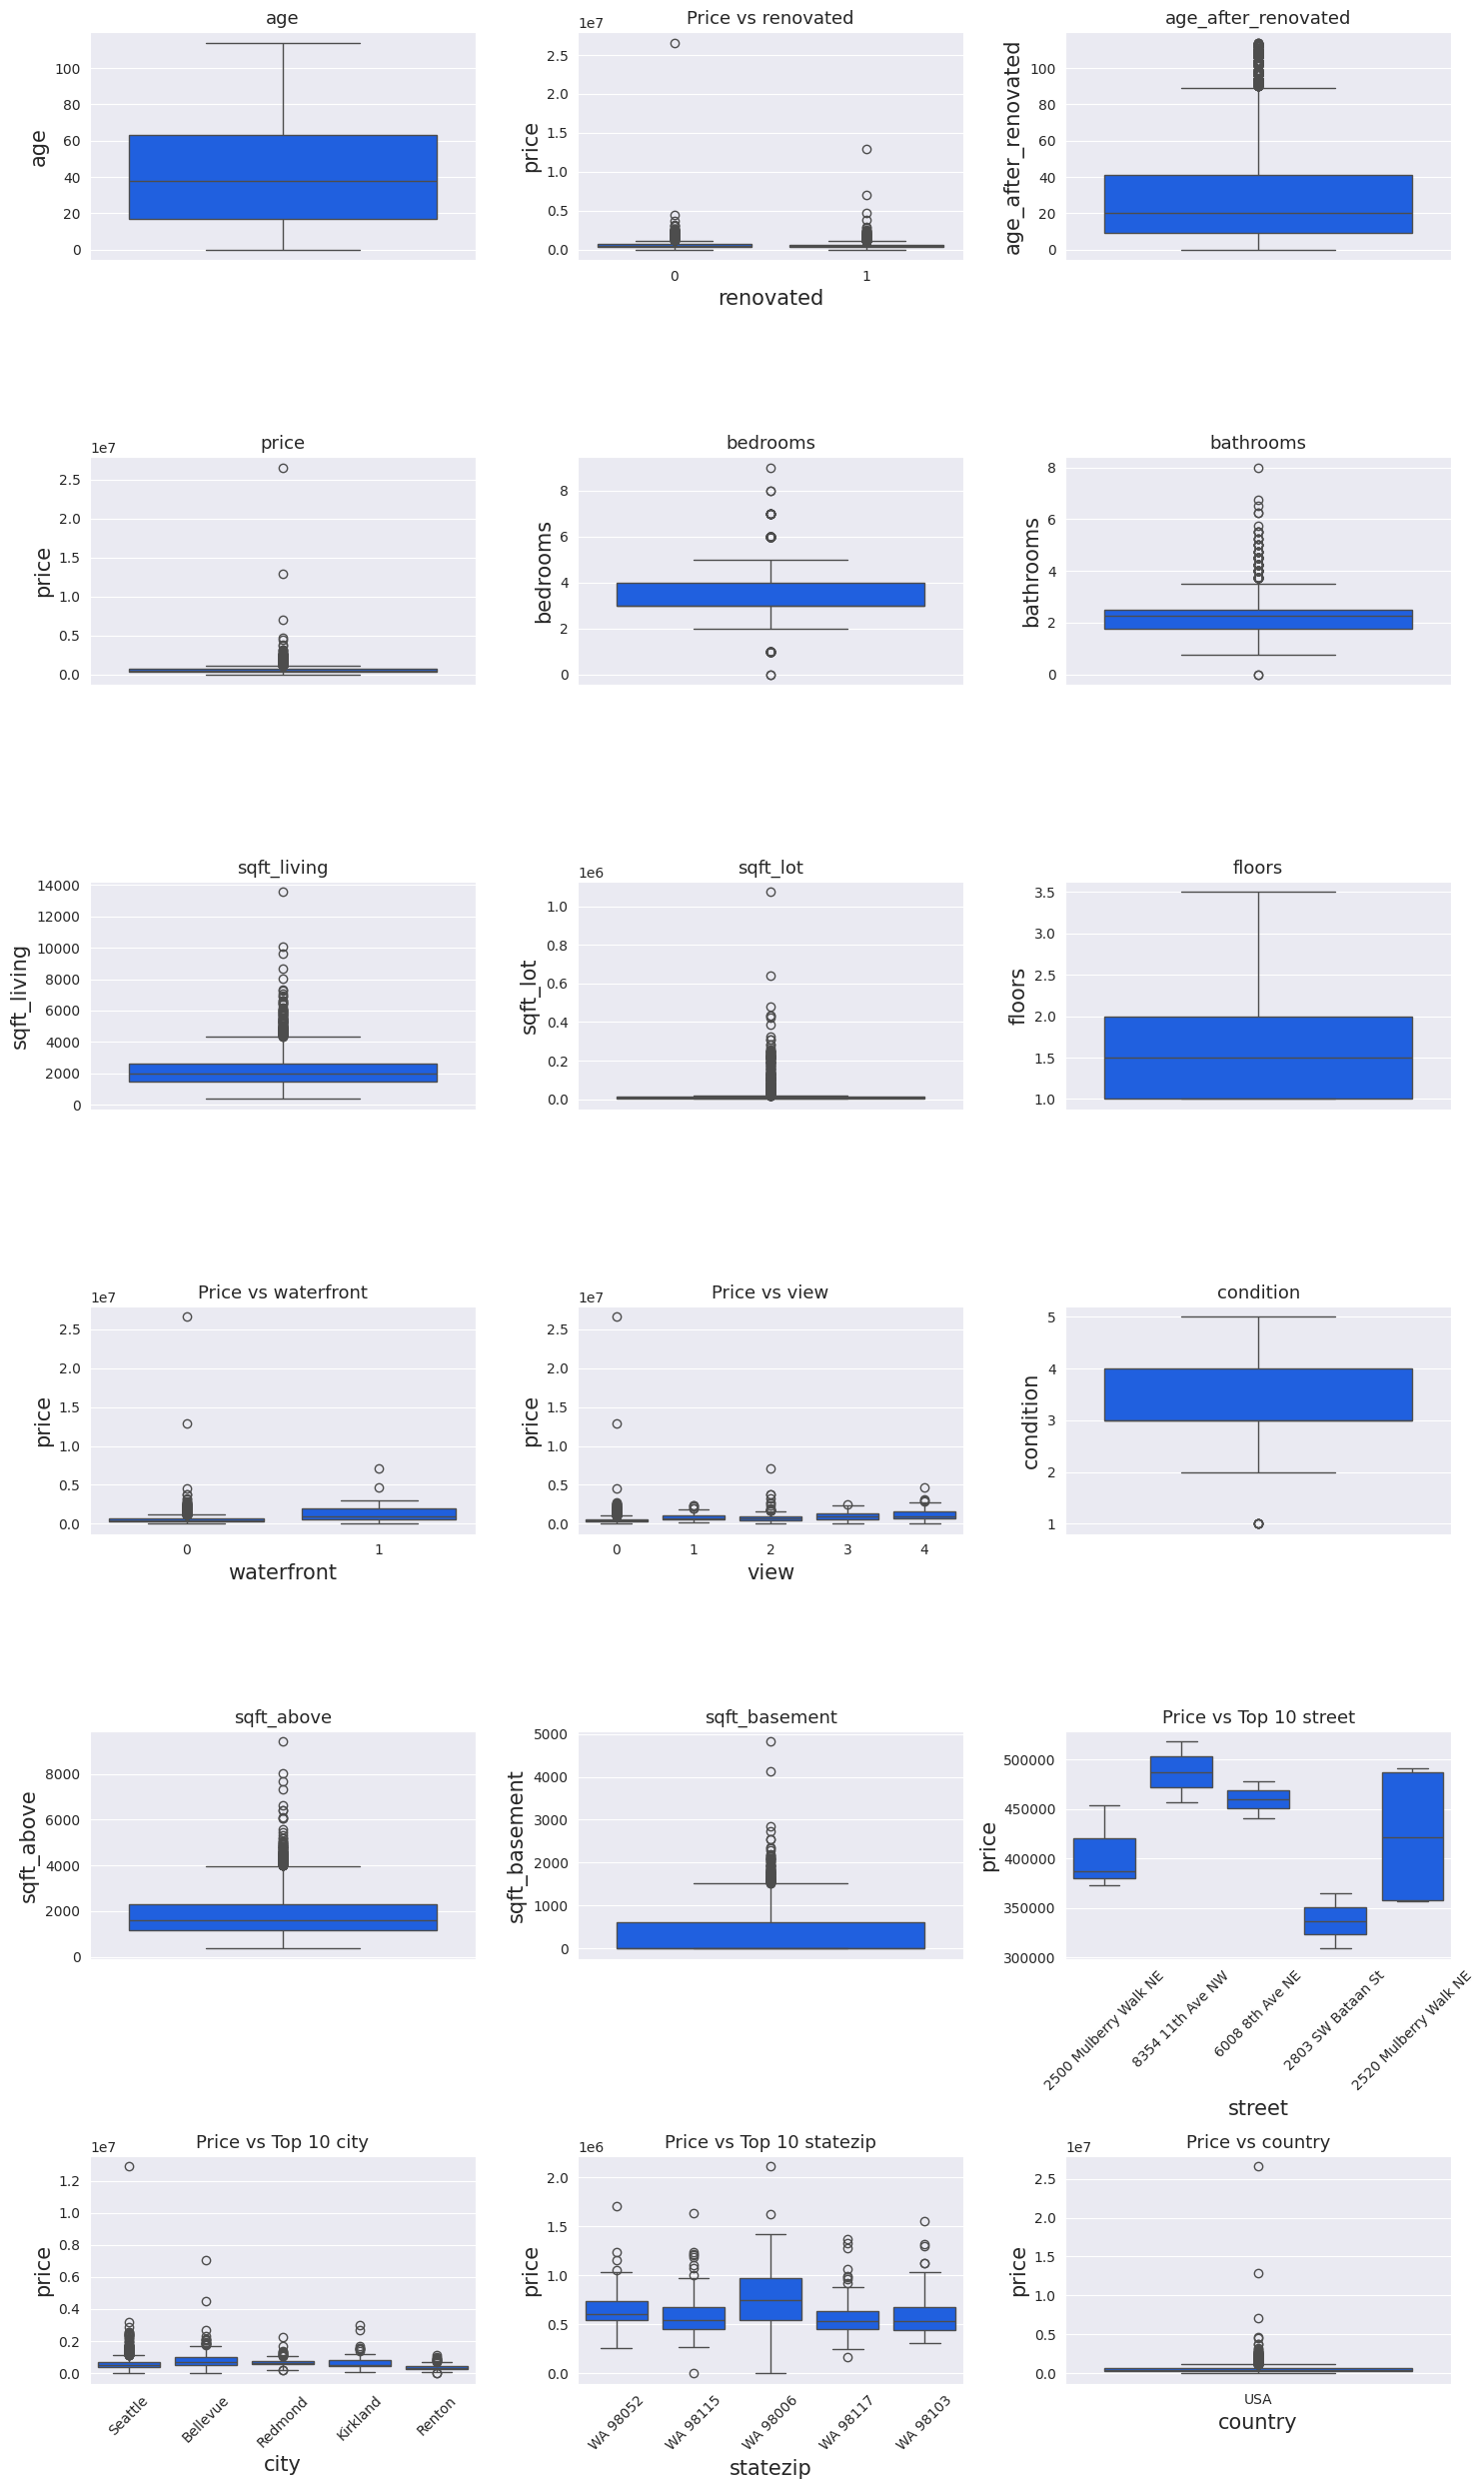

In [11]:
sns.set_style('darkgrid')
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))

OrderedCols = np.concatenate([
    df.select_dtypes(exclude='object').columns.values,
    df.select_dtypes(include='object').columns.values
])

binary_x_cols = ['waterfront', 'view', 'renovated']
high_cardinality_cols = ['street', 'city', 'statezip']

df_top = df.copy()
for col in high_cardinality_cols:
  top_values = df[col].value_counts().nlargest(5).index
  df_top[col] = df[col].where(df[col].isin(top_values), np.nan)

fig, ax = plt.subplots(6, 3, figsize=(15, 25), dpi=100)

for i, col in enumerate(OrderedCols):
    x = i //3
    y = i %3

    if col in binary_x_cols:
        sns.boxplot(data=df_top, x=col, y='price', ax=ax[x, y])
        ax[x, y].set_title(f'Price vs {col}', fontsize=13)
        ax[x, y].xaxis.label.set_size(15)
        ax[x, y].yaxis.label.set_size(15)

    elif col in high_cardinality_cols:
        sns.boxplot(data=df_top, x=col, y='price', ax=ax[x, y])
        ax[x, y].set_title(f'Price vs Top 10 {col}', fontsize=13)
        ax[x, y].tick_params(axis='x', rotation=45)
        ax[x, y].xaxis.label.set_size(15)
        ax[x, y].yaxis.label.set_size(15)

    # Corrected indentation for this elif block and its contents
    elif i < 14:
        sns.boxplot(data=df, y=col, ax=ax[x, y])
        ax[x, y].set_title(f'{col}', fontsize=13)
        ax[x, y].yaxis.label.set_size(15)

    # Corrected indentation for this else block and its contents
    else:
      sns.boxplot(data=df, x=col, y='price', ax=ax[x, y])
      ax[x, y].set_title(f'Price vs {col}', fontsize=13)
      ax[x, y].xaxis.label.set_size(15)
      ax[x, y].yaxis.label.set_size(15)

plt.tight_layout()
plt.show()

In [12]:
outliers_indexes = []
target = 'price'

# Treat these numerical columns as categorical
custom_categorical = ['renovated', 'waterfront', 'view']

# Categorical columns (including object types + custom categorical)
categorical_cols = list(df.select_dtypes(include='object').columns) + custom_categorical

# Loop through categorical columns
for col in categorical_cols:
  for cat in df[col].unique():
    df2 = df[df[col] == cat]
    q1 = df2[target].quantile(0.25)
    q3 = df2[target].quantile(0.75)
    iqr = q3-q1
    maximum = q3 + (1.5 * iqr)
    minimum = q1- (1.5 * iqr)
    outlier_samples = df2[(df2[target] < minimum) | (df2[target] > 5000000)]
    outliers_indexes.extend(outlier_samples.index.tolist())

# Numerical columns
numerical_cols = [
    col for col in df.select_dtypes(exclude='object').columns
    if col not in ['street'] + custom_categorical
]

for col in numerical_cols:
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3-q1
  maximum = q3 + (1.5 * iqr)
  minimum = q1- (1.5 * iqr)
  outlier_samples = df[(df[col] < minimum) | (df[col] > 5000000)]
  outliers_indexes.extend(outlier_samples.index.tolist())

# Remove duplicate indices
outliers_indexes = list(set(outliers_indexes))

# Output
print('{} outliers were identified, whose indices are:\n\n{}'.
      format(len(outliers_indexes), outliers_indexes))

98 outliers were identified, whose indices are:

[2560, 3590, 529, 4113, 3605, 4117, 3608, 1051, 3633, 3129, 2625, 588, 3668, 3678, 1140, 4216, 1663, 3209, 4237, 1678, 3769, 1216, 3778, 1219, 2765, 1238, 2286, 4338, 4346, 4350, 2303, 4351, 3326, 4354, 260, 4358, 4362, 2318, 784, 4374, 4376, 4382, 2337, 4386, 290, 4389, 1833, 4394, 4407, 4408, 4411, 4412, 4413, 1853, 4415, 831, 2365, 4420, 4425, 4442, 4447, 4448, 4454, 2919, 4456, 3945, 2416, 1906, 883, 4472, 4479, 4480, 4481, 4487, 908, 1422, 402, 4499, 2966, 4520, 4521, 4522, 4528, 4534, 4541, 4542, 4552, 969, 4554, 4555, 4556, 4563, 4567, 3034, 477, 4574, 4588, 1018]


In [13]:
df.drop('street', axis=1, inplace=True)

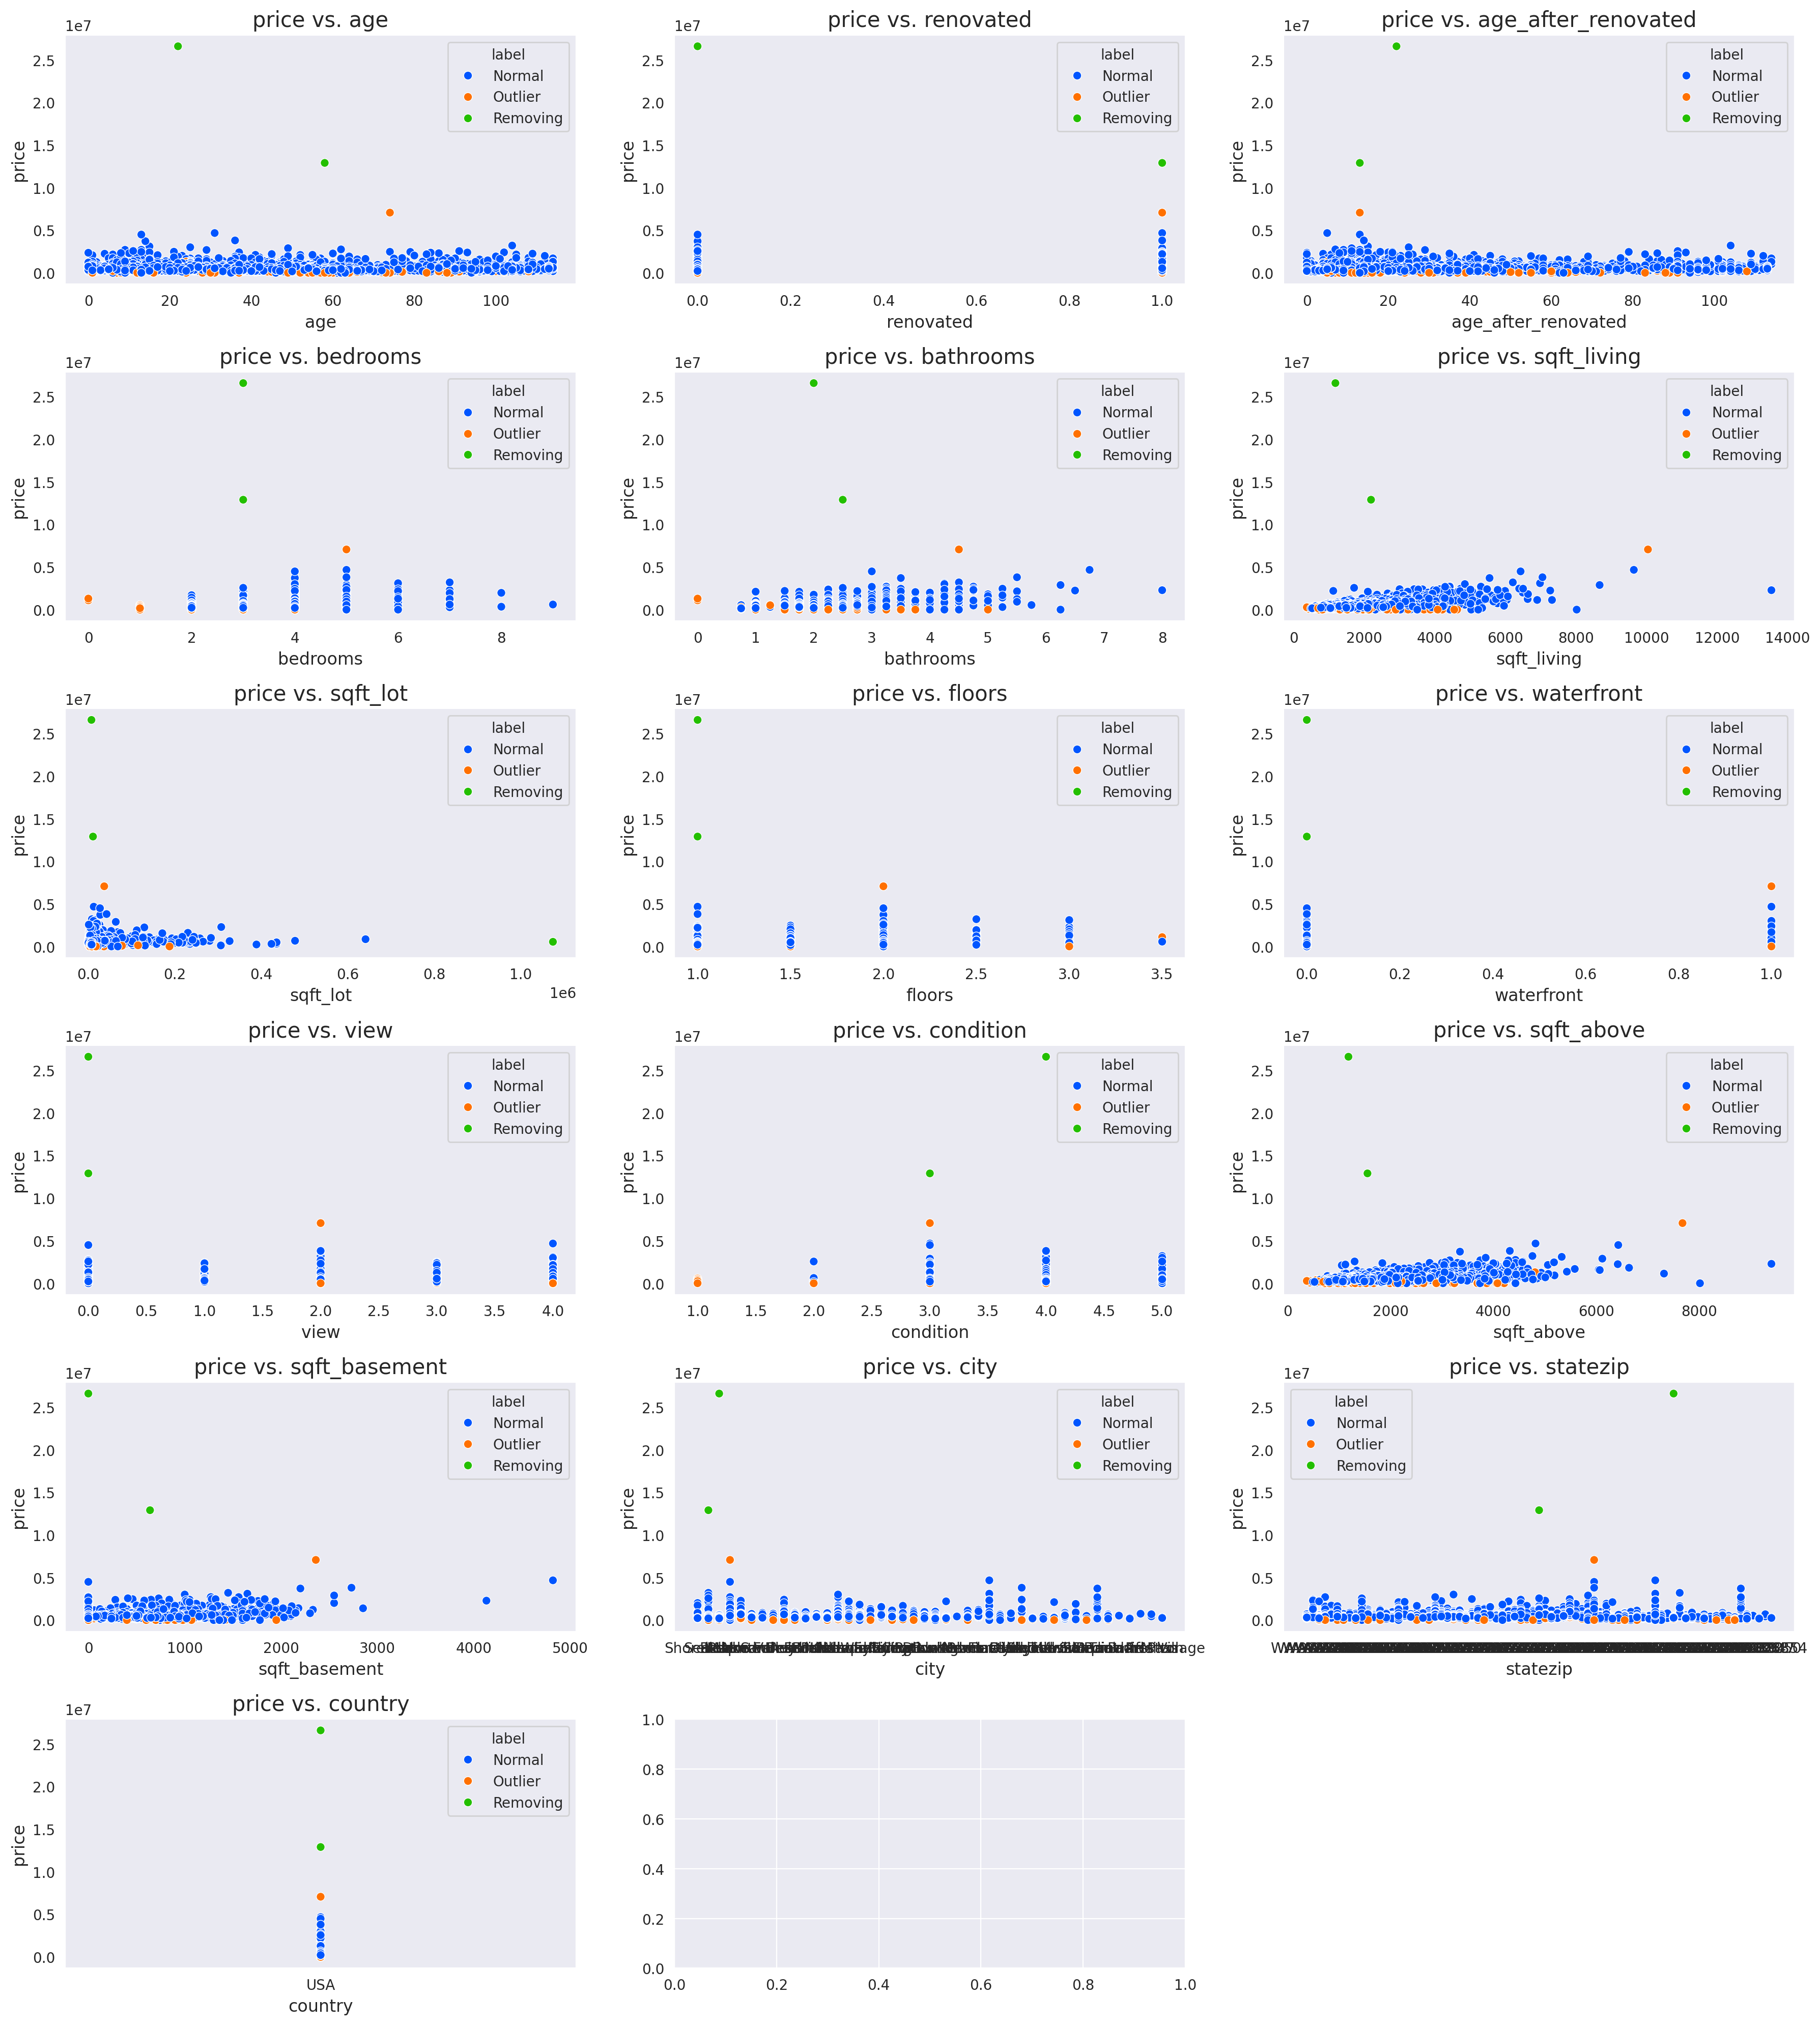

In [14]:
# Label outliers from earlier logic
df2 = df.copy()
df2['label'] = 'Normal'
df2.loc[outliers_indexes, 'label'] = 'Outlier'

# Domain-based rules to remove additional outliers
removing_indexes = []

# New custom domain-based conditions
removing_indexes.extend(df2[df2['price'] > 12000000].index)
removing_indexes.extend(df2[df2['sqft_lot'] > 900000].index)

# Mark those rows as 'Removing'
df2.loc[removing_indexes, 'label'] = 'Removing'

# Plotting
target = 'price'
features = df.columns.drop(target)
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))

fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(18, 20), dpi=200)

for i in range(len(features)):
    x = i // 3
    y = i % 3
    sns.scatterplot(data=df2, x=features[i], y=target, hue='label', ax=ax[x, y])
    ax[x, y].set_title('{} vs. {}'.format(target, features[i]), size=15)
    ax[x, y].set_xlabel(features[i], size=12)
    ax[x, y].set_ylabel(target, size=12)
    ax[x, y].grid()

# Turn off the last unused subplot (18th slot)
if len(features) < 18:
  ax[5, 2].axis('off')

plt.tight_layout()
plt.show()

In [15]:
removing_indexes = list(set(removing_indexes))
removing_indexes

[1078, 4346, 4350]

In [16]:
# Check if there's any null data in our dataset.
df.isnull().sum()

,0
age,0
renovated,0
age_after_renovated,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0


In [17]:
df2 = df.copy()
df2.drop(removing_indexes, inplace=True)
df2.reset_index(drop=True, inplace=True)

**3. Analyze the Dataset**

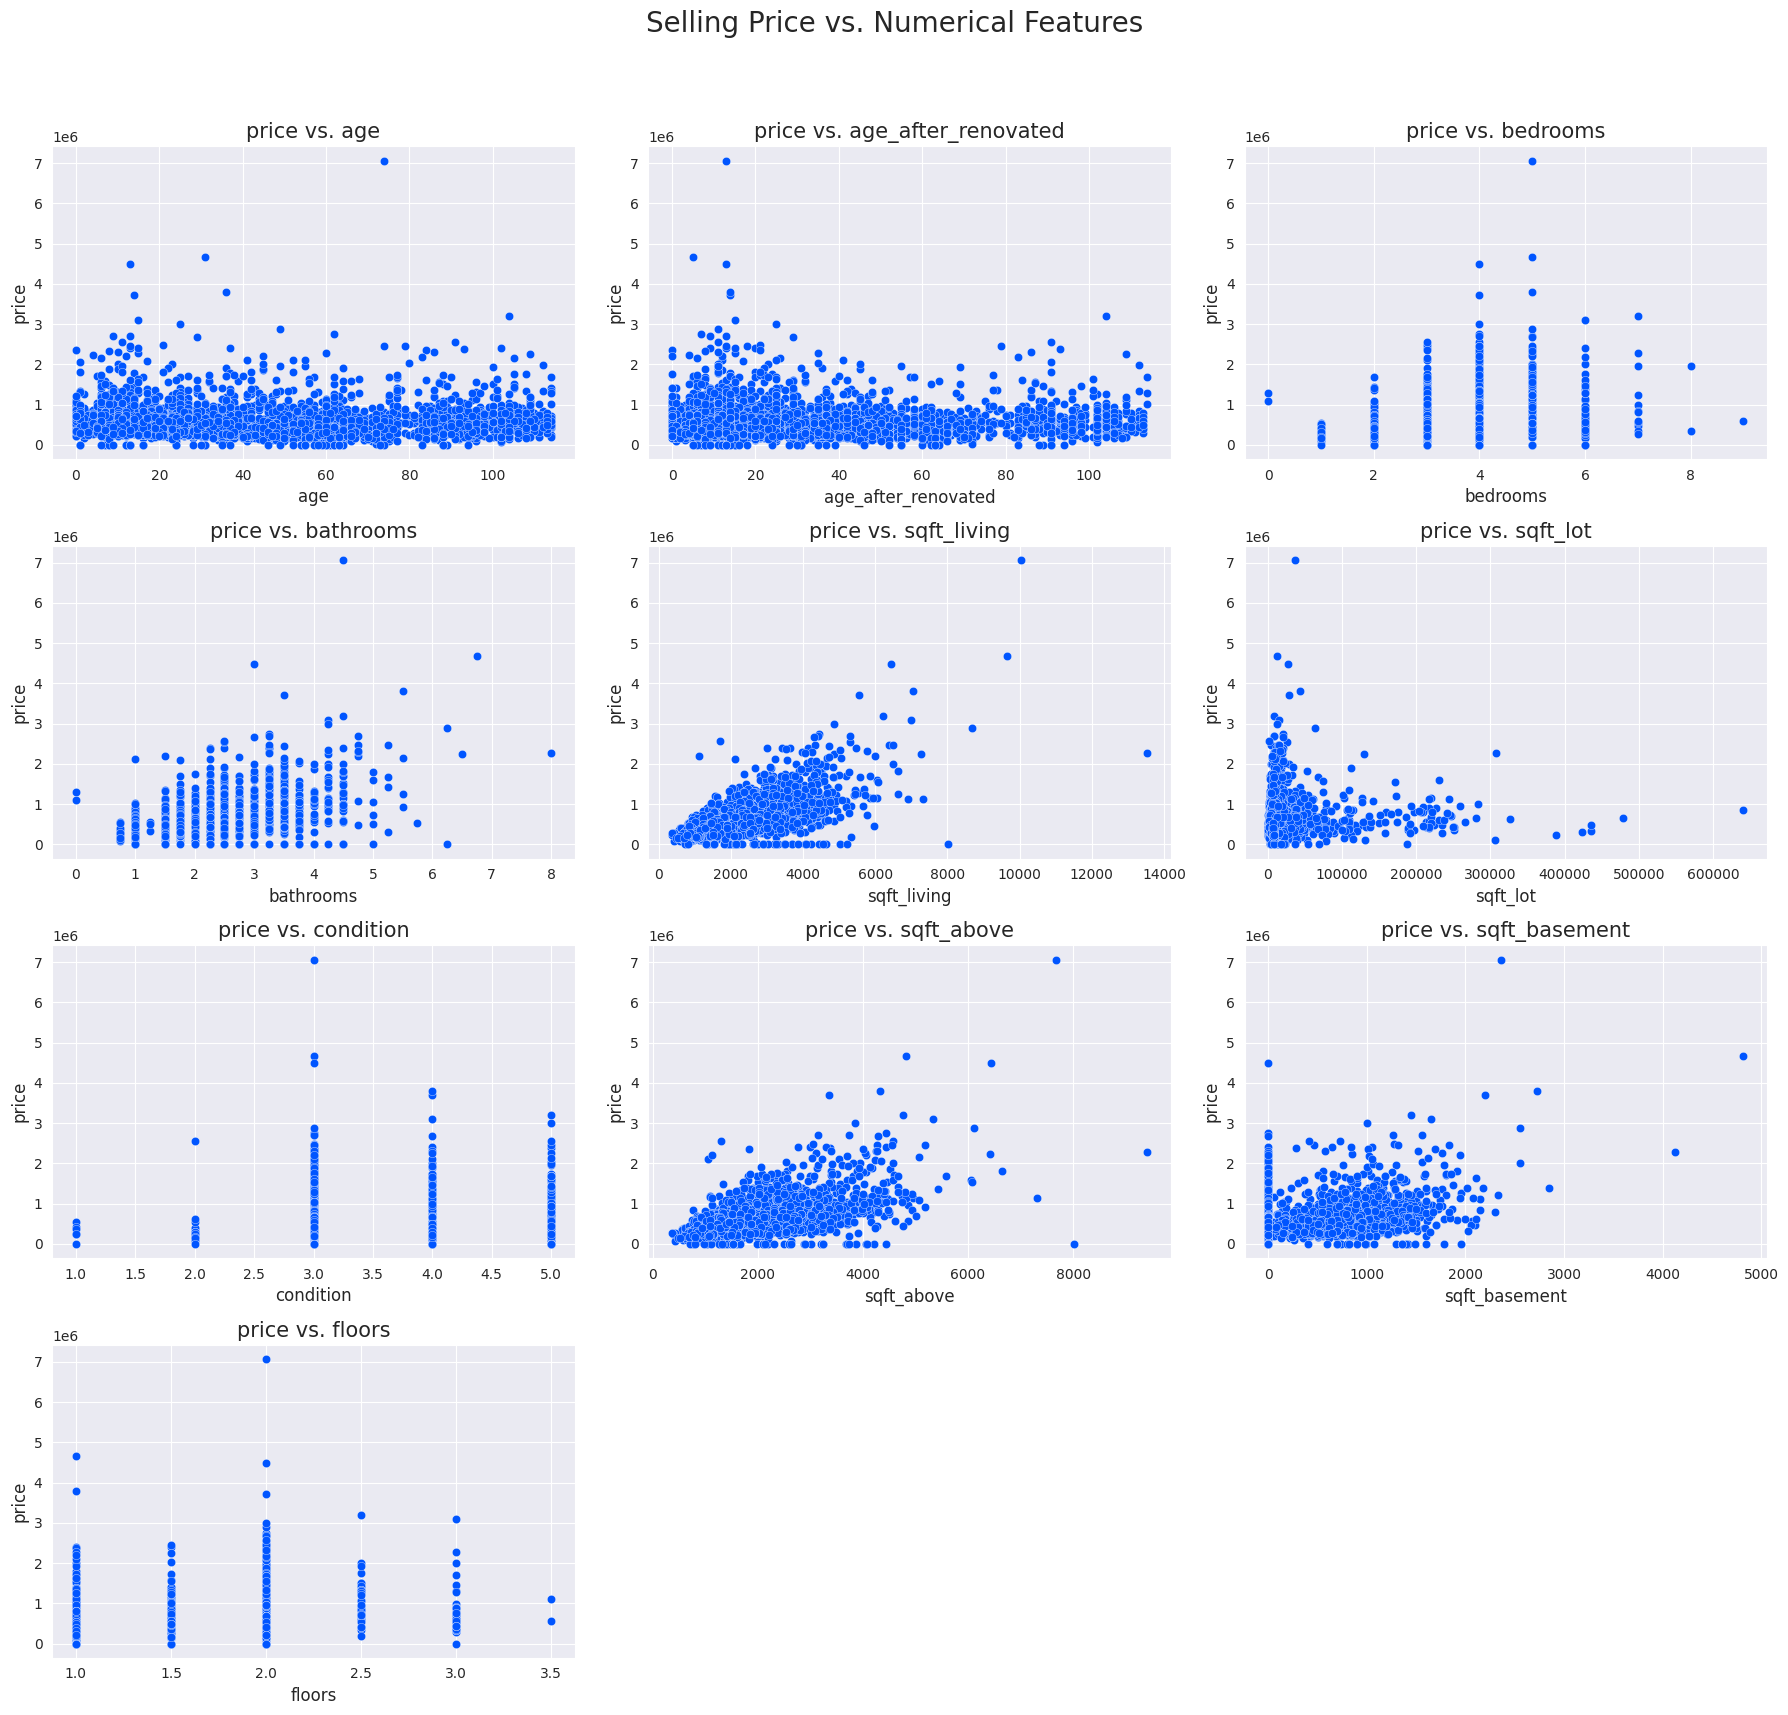

In [19]:
# List of 10 numerical features
num_features = [
    'age', 'age_after_renovated', 'bedrooms', 'bathrooms',  'sqft_living', 'sqft_lot', 'condition', 'sqft_above', 'sqft_basement','floors'
]

target = 'price'
c = '#0055ff'

# Set up the 4x3 grid of subplots
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(18, 18), dpi=100)
ax = ax.flatten()

# Plot each feature
for i in range(len(num_features)):
  feature = num_features[i]
  ax[i].scatter(df2[feature], df2[target], color=c, edgecolors='w', linewidths=0.25)
  ax[i].set_title(f'{target} vs. {feature}', size=15)
  ax[i].set_xlabel(feature, size=12)
  ax[i].set_ylabel(target, size=12)
  ax[i].grid(True)

# Hide any unused subplots (only 10 of 12 are used)
for j in range(len(num_features), len(ax)):
  fig.delaxes(ax[j])

# Final layout
plt.suptitle('Selling Price vs. Numerical Features', size=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

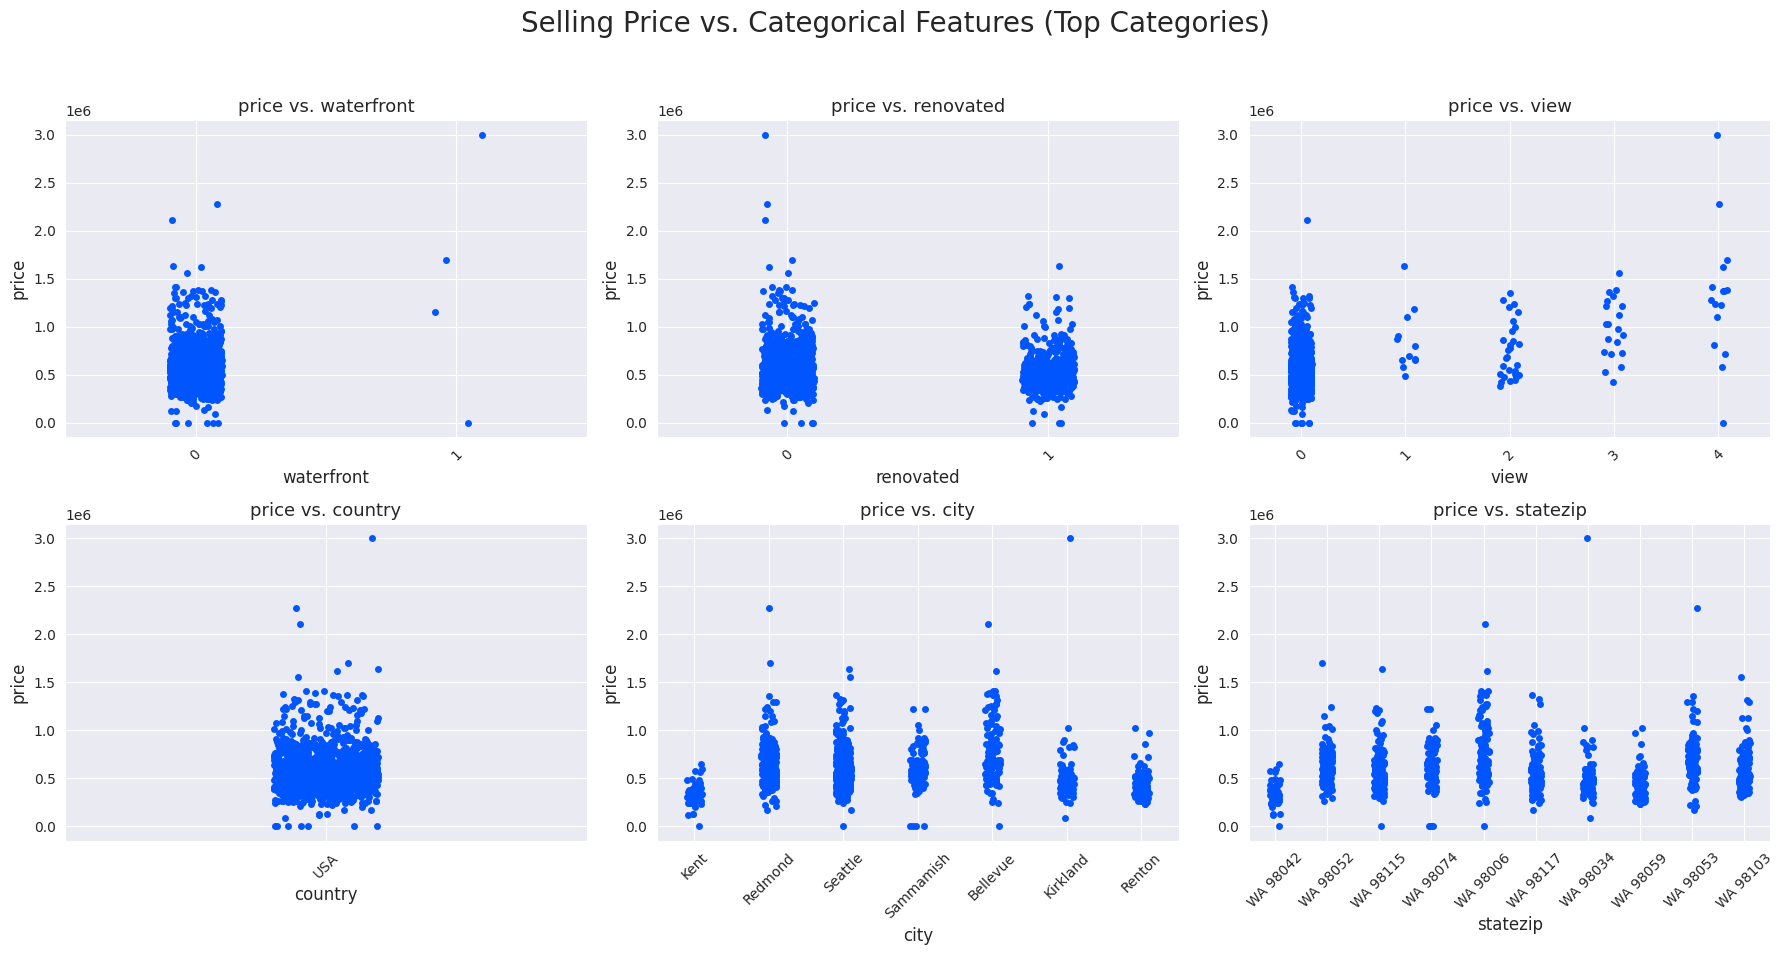

In [20]:
# Define categorical features and target
cat_features = ['waterfront', 'renovated','view', 'country', 'city', 'statezip']
target = 'price'
c = '#0055ff'

# Copy dataframe for safe manipulation
df_plot = df2.copy()

# Limit 'city' and 'statezip' to top 10 categories
top_cities = df_plot['city'].value_counts().nlargest(10).index
top_zips = df_plot['statezip'].value_counts().nlargest(10).index
df_plot = df_plot[df_plot['city'].isin(top_cities)]
df_plot = df_plot[df_plot['statezip'].isin(top_zips)]

# Set up the 2x3 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), dpi=100)
axes = axes.flatten()

# Generate strip plots
for i in range(len(cat_features)):
  sns.stripplot(ax=axes[i], x=cat_features[i], y=target, data=df_plot, size=5, color=c)
  axes[i].set_title(f'{target} vs. {cat_features[i]}', size=13)
  axes[i].set_xlabel(cat_features[i], size=12)
  axes[i].set_ylabel(target, size=12)
  axes[i].tick_params(axis='x', rotation=45) # Rotate x-axis labels
  axes[i].grid(True)

# Remove the unused 6th subplot
for j in range(len(cat_features), len(axes)):
  fig.delaxes(axes[j])

# Final formatting
plt.suptitle('Selling Price vs. Categorical Features (Top Categories)', size=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [21]:
# Define categorical columns
CatCols = ['waterfront', 'renovated', 'view', 'country', 'city', 'statezip']

# Get top 10 most frequent cities and zip codes
top_cities = df2['city'].value_counts().nlargest(10).index
top_zips = df2['statezip'].value_counts().nlargest(10).index

# Replace less frequent values with 'Other'
df2['city'] = df2['city'].apply(lambda x: x if x in top_cities else 'Other')
df2['statezip'] = df2['statezip'].apply(lambda x: x if x in top_zips else'Other')

# One-hot encode all categorical columns (drop_first avoids multicollinearity)
df2 = pd.get_dummies(df2, columns=CatCols, drop_first=True)

# Preview result
df2.head(5)

,age,age_after_renovated,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,sqft_above,...,statezip_WA 98006,statezip_WA 98034,statezip_WA 98042,statezip_WA 98052,statezip_WA 98053,statezip_WA 98059,statezip_WA 98074,statezip_WA 98103,statezip_WA 98115,statezip_WA 98117
0,59,9,313000.0,3.0,1.50,1340,7912,1.5,3,1340,...,False,False,False,False,False,False,False,False,False,False
1,93,93,2384000.0,5.0,2.50,3650,9050,2.0,5,3370,...,False,False,False,False,False,False,False,False,False,False
2,48,48,342000.0,3.0,2.00,1930,11947,1.0,4,1930,...,False,False,True,False,False,False,False,False,False,False
3,51,51,420000.0,3.0,2.25,2000,8030,1.0,4,1000,...,False,False,False,False,False,False,False,False,False,False
4,38,22,550000.0,4.0,2.50,1940,10500,1.0,4,1140,...,False,False,False,True,False,False,False,False,False,False


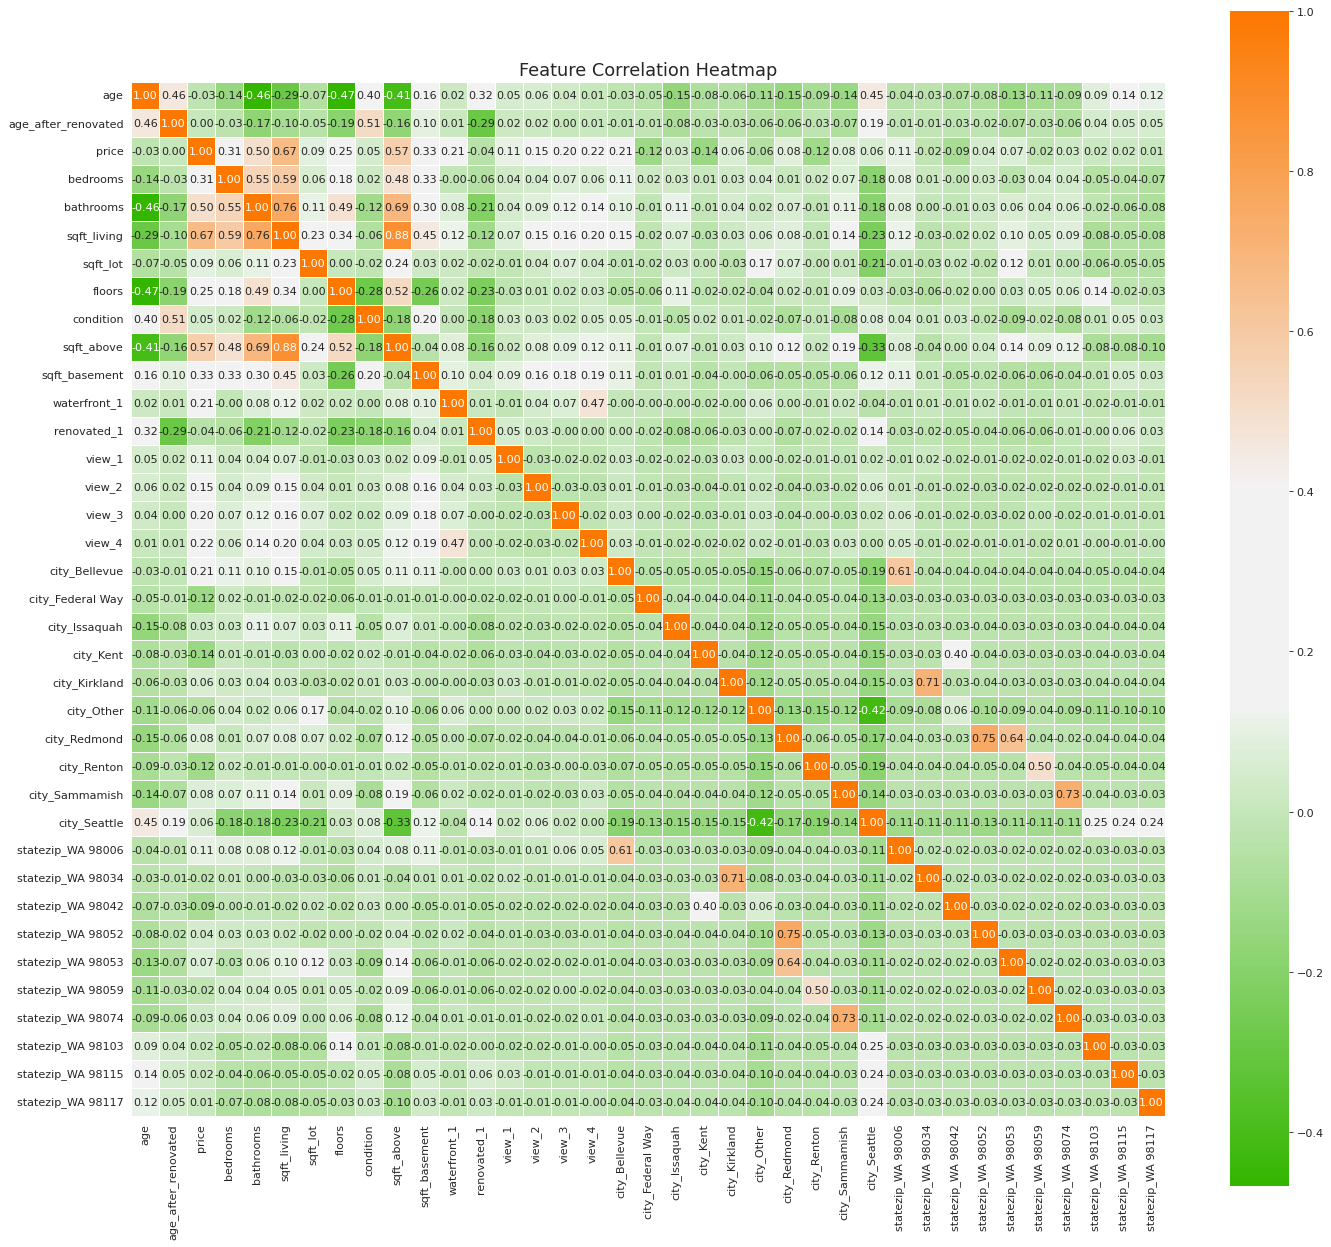

In [22]:
target = 'price'
cmap = sns.diverging_palette(125, 28, s=100, l=65, sep=50, as_cmap=True)

# Drop 'city' and 'statezip' before correlation
df_corr = df2.drop(columns=['city', 'statezip'], errors='ignore')

# Create the heatmap
fig, ax = plt.subplots(figsize=(18, 16), dpi=80)
ax = sns.heatmap(df_corr.corr(), annot=True, cmap=cmap, fmt=".2f", square=True, linewidths=0.5)

plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

**4. Build the Machine Learning Model**

**i. Normalize the Dataset**

In [23]:
# Remove the "price" from input and set it to output. This means that it has to be predicted.
X = df2.drop('price', axis=1)
y = df2['price']

In [24]:
# Split our dataset by taking 70% of data for training and 30% of data for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Make a backup of our test data. We need this for the final comparison.
y_test_actual = y_test

In [25]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

**ii. Train the Model**

In [26]:
# Initialize and train model
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [27]:
pd.DataFrame(data = np.append(linear_reg.intercept_ , linear_reg.coef_), index = ['Intercept']+[col+" Coef." for col in X.columns], columns=['Value']).sort_values('Value', ascending=False)

,Value
Intercept,546402.929649
sqft_living Coef.,129119.694678
sqft_above Coef.,122601.380427
city_Seattle Coef.,120404.898528
city_Bellevue Coef.,104454.768029
city_Kirkland Coef.,66348.862131
city_Other Coef.,56540.223802
city_Redmond Coef.,55476.488155
waterfront_1 Coef.,46628.243330
age Coef.,40746.300046


**iii. Evaluate the Model**

In [28]:
def model_evaluation(model, X_test, y_test, model_name):
  y_pred = model.predict(X_test)

  # Corrected indentation for the following lines
  MAE = metrics.mean_absolute_error(y_test, y_pred)
  MSE = metrics.mean_squared_error(y_test, y_pred)
  RMSE = np.sqrt(MSE)
  R2_Score = metrics.r2_score(y_test, y_pred)

  return pd.DataFrame([MAE, MSE, RMSE, R2_Score], index=['MAE', 'MSE', 'RMSE','R2-Score'], columns=[model_name])

model_evaluation(linear_reg, X_test_scaled, y_test, 'linear_reg.')

,linear_reg.
MAE,1.312619e+05
MSE,4.446164e+10
RMSE,2.108593e+05
R2-Score,6.274924e-01


In [29]:
from sklearn.model_selection import KFold, cross_validate

linear_reg_cv = LinearRegression()
scaler = StandardScaler()
pipeline = make_pipeline(StandardScaler(), LinearRegression())

kf = KFold(n_splits=6, shuffle=True, random_state=0)
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
result = cross_validate(pipeline, X, y, cv=kf, return_train_score=True, scoring=scoring)

MAE_mean = (-result['test_neg_mean_absolute_error']).mean()
MAE_std = (-result['test_neg_mean_absolute_error']).std()
MSE_mean = (-result['test_neg_mean_squared_error']).mean()
MSE_std = (-result['test_neg_mean_squared_error']).std()
RMSE_mean = (-result['test_neg_root_mean_squared_error']).mean()
RMSE_std = (-result['test_neg_root_mean_squared_error']).std()
R2_Score_mean = result['test_r2'].mean()
R2_Score_std = result['test_r2'].std()

pd.DataFrame({'Mean': [MAE_mean, MSE_mean, RMSE_mean, R2_Score_mean], 'Std': [MAE_std, MSE_std, RMSE_std, R2_Score_std]}, index=['MAE', 'MSE', 'RMSE', 'R2-Score'])

,Mean,Std
MAE,1.377305e+05,7.328627e+03
MSE,5.672909e+10,1.071966e+10
RMSE,2.371375e+05,2.224602e+04
R2-Score,5.806151e-01,4.880259e-02


**5. Results Visualization**

In [30]:
y_test_pred = linear_reg.predict(X_test_scaled)
df_comp = pd.DataFrame({'Actual':y_test_actual, 'Predicted':y_test_pred})

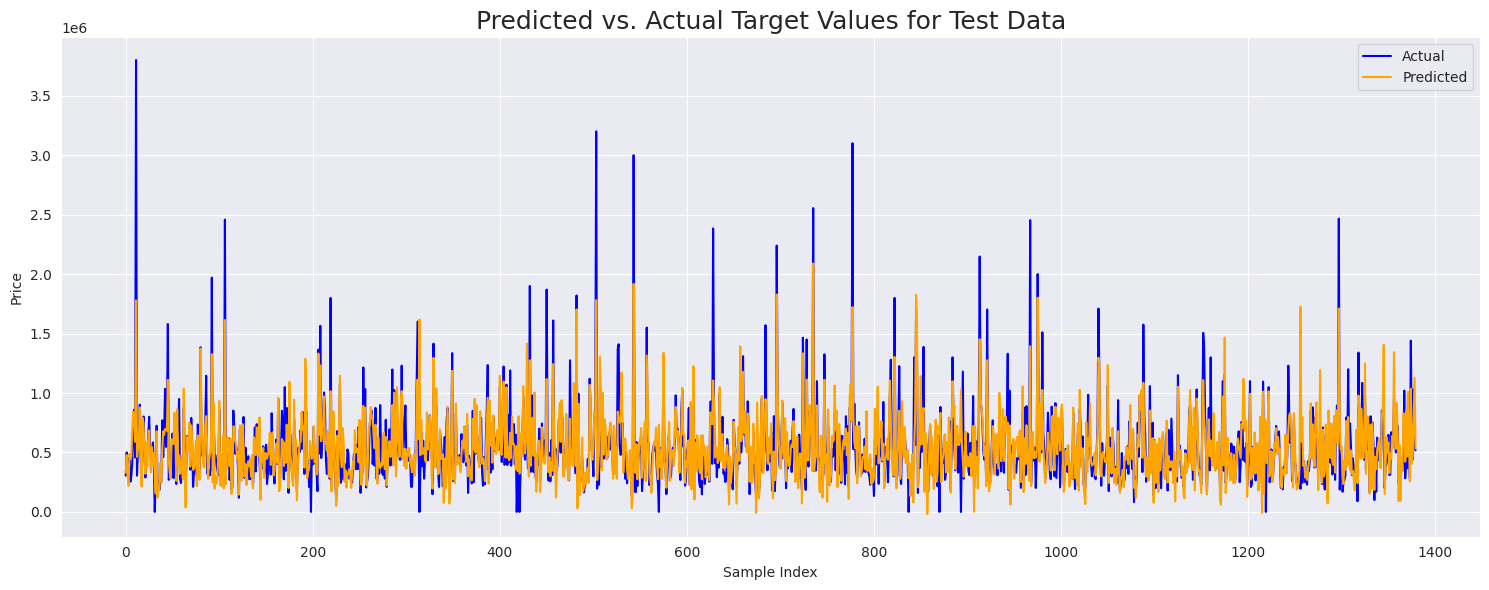

In [31]:
def compare_plot(df_comp):
  plt.figure(figsize=(15, 6))
  plt.plot(df_comp['Actual'].values, label='Actual', color='blue')
  plt.plot(df_comp['Predicted'].values, label='Predicted', color='orange')
  plt.title('Predicted vs. Actual Target Values for Test Data', fontsize=18)
  plt.xlabel('Sample Index')
  plt.ylabel('Price')
  plt.legend()
  plt.tight_layout()
  plt.show()

compare_plot(df_comp)